# Machine Learning for Portfolio Management and Trading project

### Notebook structure :

1.	Introduction : Outlines the project’s context, objective and contributions.
2.	Data : Details the sources, preprocessing steps, and exploration of the datasets.
3.	Methodology : Describes the building of indicators and machine learning models, as well as experimental setup employed.
4.	Results and analysis : Presents the empirical findings, visualizations, and interpretations of the data.
5.	Discussion : Analyzes the implications, limitations, and potential future directions of the study.
6.	Conclusion : Summarizes the key takeaways and the overall significance of the research.

## 1 - Introduction

The aim of our project is to use data from speeches by FED officials, scraped from the site, to determine a signal about economic conditions. After using NLP techniques to construct this signal, we deploy a RandomForest model to predict the log-returns of Treasury bills over a 10-year horizon. Features include our indicator, as well as other macro indicators useful for prediction. We then develop a simple trading strategy, which consists of going long if our model predicts a rise, and going short if it does not.

## 2 - Data

In [ ]:
# Prerequisites
!pip install selenium
!pip install webdriver-manager
!pip install fredapi

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager
from scipy.stats import norm
from statsmodels.tsa.stattools import grangercausalitytests
from fredapi import Fred
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

### Scrapping the data

In this section, we provide the code to obtain speech data for all FED officials since 2006. We have scraped the data from the following link : https://www.federalreserve.gov/newsevents/speeches.htm. As a first step (first cell), we've provided the code that scrapes the first page, to show you how well it works. Execution time is approximately 1 minute 30 seconds. However, scrapping all the speeches since 2006, i.e. all 58 pages on the site, takes over an hour. It's the code in the second cell that makes this possible. We therefore do not recommend that you run this cell. To make things easier, we've extracted the file we put on our GitHub repo (https://github.com/cominho/Machine-Learning-for-Portfolio-Management-and-Trading/blob/main/fomc_speeches.xlsx), and import it directly via the repo URL (so no need for external files to the notebook). As a result, you can start the project directly from the third cell of the notebook (sub-section "Data cleaning and formatting").


In [ ]:
# Example : code to scrap all the documents of page 1

class FomcSpeech:
    def __init__(self):
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--disable-gpu")
        chrome_options.add_argument("--window-size=1920x1080")
        chrome_options.binary_location = "/Applications/Google Chrome.app/Contents/MacOS/Google Chrome"

        self.driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        self.base_url = "https://www.federalreserve.gov/newsevents/speeches.htm"

    def scroll_page(self):
        """Automatically scrolls the page to load all the speeches."""
        last_height = self.driver.execute_script("return document.body.scrollHeight")
        while True:
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(3)
            new_height = self.driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height
        print("Scroll over.")

    def get_speeches(self):
        """Retrieves all links and content."""
        print(f"Access to the page : {self.base_url}")
        self.driver.get(self.base_url)
        time.sleep(5)

        # Scroll to load all the speeches
        self.scroll_page()

        speeches = []
        # Find the links of the speeches
        links = self.driver.find_elements(By.CSS_SELECTOR, "div.col-xs-9 a")
        print(f"Number of links found : {len(links)}")

        for link in links:
            try:
                title = link.text.strip()
                url = link.get_attribute("href")
                print(f"Speech found : {title} - {url}")
                speeches.append({'Title': title, 'URL': url})
            except Exception as e:
                print(f"Link error : {e}")

        # Extract the content of each link
        data = []
        for speech in speeches:
            print(f"Download content : {speech['URL']}")
            try:
                self.driver.get(speech['URL'])
                time.sleep(2)
                content = self.driver.find_element(By.TAG_NAME, "body").text.strip()
                data.append({'Title': speech['Title'], 'URL': speech['URL'], 'Content': content})
            except Exception as e:
                print(f"Error for {speech['URL']} : {e}")

        self.driver.quit()
        return pd.DataFrame(data)

fomc_speech = FomcSpeech()
df_speeches = fomc_speech.get_speeches()

print("All speeches extracted :")
print(df_speeches.head())

In [ ]:
# General code for scrapping all the speeches, from 2006 to 2024

class FomcSpeech:
    def __init__(self):
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--disable-gpu")
        chrome_options.add_argument("--window-size=1920x1080")
        chrome_options.binary_location = "/Applications/Google Chrome.app/Contents/MacOS/Google Chrome"

        self.driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        self.base_url = "https://www.federalreserve.gov/newsevents/speeches.htm"
        self.speeches = []

    def extract_page_speeches(self):
        """Extrait les discours d'une page courante."""
        time.sleep(2)
        links = self.driver.find_elements(By.CSS_SELECTOR, "div.col-xs-9 a")

        for link in links:
            try:
                title = link.text.strip()
                url = link.get_attribute("href")
                print(f"Speech found : {title} - {url}")
                if "Watch Live" not in title:  # Filter relevant links : we don't want videos
                    self.speeches.append({'Title': title, 'URL': url})
            except Exception as e:
                print(f"Error for a link : {e}")

    def go_to_next_page(self, current_page):
        """Go to the next page by using 'Next' or '...' if possible."""
        try:
            if current_page >= 58:
                print("Page 58 reached. Stopping pagination.")
                return False

            next_button = self.driver.find_element(By.LINK_TEXT, "Next")
            self.driver.execute_script("arguments[0].click();", next_button)
            time.sleep(2)
            return True
        except Exception:
            try:
                # Click on '...' if Next is not visible
                ellipsis = self.driver.find_element(By.LINK_TEXT, "...")
                self.driver.execute_script("arguments[0].click();", ellipsis)
                time.sleep(2)
                return True
            except Exception as e:
                print(f"End of pagination or error : {e}")
                return False

    def get_speeches(self):
        """Retrieves all paged speeches."""
        self.driver.get(self.base_url)
        time.sleep(3)

        page_number = 1
        while page_number <= 58:  # Limit in the total number of pages
            print(f"--- Speech extraction - Page {page_number} ---")
            self.extract_page_speeches()

            # Next page
            if not self.go_to_next_page(page_number):
                break
            page_number += 1

        # Extract the content of the speech
        data = []
        for speech in self.speeches:
            try:
                print(f"Content extraction : {speech['URL']}")
                self.driver.get(speech['URL'])
                time.sleep(2)
                content = self.driver.find_element(By.TAG_NAME, "body").text.strip()
                data.append({'Title': speech['Title'], 'URL': speech['URL'], 'Content': content})
            except Exception as e:
                print(f"Error for {speech['URL']} : {e}")

        self.driver.quit()
        return pd.DataFrame(data)

fomc_speech = FomcSpeech()
df_speeches = fomc_speech.get_speeches()

# Print results
print("All speeches extracted :")
print(df_speeches.head())

### Data cleaning and formatting

As the code took more than an hour to run, we've provided a final version in xlsx format here.

In [ ]:
url_speeches = "https://raw.githubusercontent.com/cominho/Machine-Learning-for-Portfolio-Management-and-Trading/main/fomc_speeches.xlsx"
df_speeches = pd.read_excel(url_speeches)
df_speeches

,Title,URL,Content
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...


In [ ]:
# First create 2 columns : author and date. We extract these informations from the URL link
import re
def extract_date(url):
    match = re.search(r'(\d{8})', url)
    if match:
        return match.group(1)
    return None

def extract_author(url):
    match = re.search(r'/speech/([a-z]+)\d{8}a?\.htm', url)
    if match:
        return match.group(1).capitalize()
    return None

df_speeches['date'] = df_speeches['URL'].apply(extract_date)
df_speeches['date'] = pd.to_datetime(df_speeches['date'])
df_speeches['author'] = df_speeches['URL'].apply(extract_author)
df_speeches

,Title,URL,Content,date,author
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-03,Kugler
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-02,Waller
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-22,Bowman
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Bowman
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Cook
...,...,...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-24,Bernanke
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-23,Ferguson
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-06,Bernanke
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-02,Bies


In [ ]:
# Clean speeches
def clean_speech(text):
    # Delete useless items before the title
    text = re.sub(r"^.*?(Speech\s*PDF\s*\n*.*?(\d{4})).*?\n", r"\2\n", text, flags=re.DOTALL)
    # Delete useless items after the end of the speech
    text = re.sub(r"Last Update:.*|BOARD OF GOVERNORS.*", "", text, flags=re.DOTALL)
    text = re.sub(r"(Skip to main content|Stay Connected|Recent Postings|Calendar|Publications|Site Map|Advanced|Submit Search Button).*?\n", "", text)
    text = re.sub(r"\n{2,}", "\n", text)
    text = text.strip()

    return text

df_speeches['cleaned_speeches'] = df_speeches['Content'].apply(clean_speech)
df_speeches

,Title,URL,Content,date,author,cleaned_speeches
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-03,Kugler,2024\nA Year in Review: A Tale of Two Supply S...
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-02,Waller,2024\nCut or Skip?\nGovernor Christopher J. Wa...
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-22,Bowman,2024\nArtificial Intelligence in the Financial...
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Bowman,2024\nApproaching Policymaking Pragmatically\n...
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Cook,2024\nEconomic Outlook\nGovernor Lisa D. Cook\...
...,...,...,...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-24,Bernanke,A-Z index\nCareers\nFAQs\nVideos\nContact\nSea...
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-23,Ferguson,A-Z index\nCareers\nFAQs\nVideos\nContact\nSea...
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-06,Bernanke,A-Z index\nCareers\nFAQs\nVideos\nContact\nSea...
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-02,Bies,A-Z index\nCareers\nFAQs\nVideos\nContact\nSea...


In [ ]:
# We observe that speeches always start after the word "Share", so we will delete all the useless information before this word
# However, we have to be careful if several occurrences of this word appear in the same speech.

df_speeches['share_count'] = df_speeches['Content'].apply(lambda x: x.count('Share'))

observations_with_multiple_shares = df_speeches[df_speeches['share_count'] > 1]

count = observations_with_multiple_shares.shape[0]

print(f"Number of observations with the word 'Share' appearing more than once : {count}")

Number of observations with the word 'Share' appearing more than once : 34


In [ ]:
def clean_content(text, share_count):
    if share_count == 1:
        return re.sub(r'^.*?Share', '', text, flags=re.DOTALL).strip()
    else:
        return text

df_speeches['cleaned_speeches'] = df_speeches.apply(
    lambda row: clean_content(row['cleaned_speeches'], row['share_count']), axis=1
)
df_speeches

,Title,URL,Content,date,author,cleaned_speeches,share_count
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-03,Kugler,"Watch Live\nThank you, Jason, and thank you fo...",1
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-02,Waller,"Watch Live\nThank you, Lydia, and thank you fo...",1
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-22,Bowman,Discussions of artificial intelligence (AI) in...,1
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Bowman,Good afternoon.1 It is a pleasure to join you ...,1
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Cook,"Thank you, Christa. It is wonderful to be with...",1
...,...,...,...,...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-24,Bernanke,It is a great pleasure for me to return to Pri...,1
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-23,Ferguson,A-Z index\nCareers\nFAQs\nVideos\nContact\nSea...,2
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-06,Bernanke,Good morning.\nI would like to begin by thanki...,1
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-02,Bies,I thank you for the invitation to speak today....,1


In [ ]:
# If share_count > 1, we delete the content before the first occurence
def clean_before_exact_share(text, share_count):
    if share_count > 1:
        pattern = r'^.*?\bShare\b'
        # Delete all content before the first occurrence of "Share"
        return re.sub(pattern, '', text, count=1, flags=re.DOTALL).strip()
    else:
        return text

df_speeches['cleaned_speeches'] = df_speeches.apply(
    lambda row: clean_before_exact_share(row['cleaned_speeches'], row['share_count']), axis=1
)

df_speeches

,Title,URL,Content,date,author,cleaned_speeches,share_count
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-03,Kugler,"Watch Live\nThank you, Jason, and thank you fo...",1
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-02,Waller,"Watch Live\nThank you, Lydia, and thank you fo...",1
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-22,Bowman,Discussions of artificial intelligence (AI) in...,1
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Bowman,Good afternoon.1 It is a pleasure to join you ...,1
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Cook,"Thank you, Christa. It is wonderful to be with...",1
...,...,...,...,...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-24,Bernanke,It is a great pleasure for me to return to Pri...,1
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-23,Ferguson,I am honored to deliver the keynote address at...,2
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-06,Bernanke,Good morning.\nI would like to begin by thanki...,1
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-02,Bies,I thank you for the invitation to speak today....,1


In [ ]:
def remove_watch_live(text):
    if text.startswith("Watch Live\n"):
        return text[len("Watch Live\n"):].strip()
    return text

df_speeches['cleaned_speeches'] = df_speeches['cleaned_speeches'].apply(remove_watch_live)
df_speeches

,Title,URL,Content,date,author,cleaned_speeches,share_count
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-03,Kugler,"Thank you, Jason, and thank you for the opport...",1
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-02,Waller,"Thank you, Lydia, and thank you for the opport...",1
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-22,Bowman,Discussions of artificial intelligence (AI) in...,1
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Bowman,Good afternoon.1 It is a pleasure to join you ...,1
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Cook,"Thank you, Christa. It is wonderful to be with...",1
...,...,...,...,...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-24,Bernanke,It is a great pleasure for me to return to Pri...,1
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-23,Ferguson,I am honored to deliver the keynote address at...,2
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-06,Bernanke,Good morning.\nI would like to begin by thanki...,1
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-02,Bies,I thank you for the invitation to speak today....,1


In [ ]:
# Export to check the modifications
# df_speeches.to_excel("/Users/come/Desktop/ENSAE/3A/fomc_cleaned.xlsx", index=False, engine='openpyxl') # change path

### Score

In [ ]:
# Import Loughran-McDonald financial dictionary from our github repo
url_dic = "https://raw.githubusercontent.com/cominho/Machine-Learning-for-Portfolio-Management-and-Trading/main/LoughranMcDonald_SentimentWordLists_2018.xlsx"
word_lists = pd.ExcelFile(url_dic)

sheet_names = [sheet for sheet in word_lists.sheet_names if sheet.lower() != "documentation"]

In [ ]:
# Format it
all_words_df = pd.DataFrame()

for sheet_name in sheet_names:
    sheet_df = pd.read_excel(word_lists, sheet_name=sheet_name, header=None, names=["Word"])
    sheet_df["Category"] = sheet_name
    all_words_df = pd.concat([all_words_df, sheet_df], ignore_index=True)

all_words_df["Word"] = all_words_df["Word"].str.strip().str.lower()
all_words_df.drop_duplicates(inplace=True)
pivot_df = (
    all_words_df
    .assign(Value=1)
    .pivot_table(index="Word", columns="Category", values="Value", fill_value=0)
    .reset_index()
)
pivot_df

Category,Word,Constraining,Litigious,Negative,Positive,StrongModal,Uncertainty,WeakModal
0,abandon,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,abandoned,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,abandoning,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,abandonment,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,abandonments,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3871,wrongdoing,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3872,wrongdoings,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3873,wrongful,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3874,wrongfully,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Coherence check
column_sums = pivot_df.iloc[:, 1:].sum()
print("Somme de chaque colonne (nombre de mots par catégorie) :")
print(column_sums)

Somme de chaque colonne (nombre de mots par catégorie) :
Category
Constraining     184.0
Litigious        904.0
Negative        2355.0
Positive         354.0
StrongModal       19.0
Uncertainty      297.0
WeakModal         27.0
dtype: float64


### 3 - Methodology

In [ ]:
def count_words_by_category(text, word_dict):
    words = text.split()
    counts = {category: 0 for category in word_dict.columns if category != "Word"}
    for word in words:
        if word in word_dict.index:
            for category in counts:
                counts[category] += word_dict.at[word, category]
    return counts

epsilon = 10^-6
results = []

for speech in df_speeches["cleaned_speeches"]:
    # Total number of words in the speech
    total_words_actual = len(speech.split())

    word_counts = count_words_by_category(speech.lower(), pivot_df.set_index("Word"))
    total_words_dict = sum(word_counts.values())  # Total number of words in the dictionary

    n_positive = word_counts.get("Positive", 0)
    n_negative = word_counts.get("Negative", 0)

    # Indicators
    if total_words_dict > 0:
        sns = (n_positive - n_negative) / total_words_dict
        rlo = np.log((n_positive + epsilon) / (n_negative + epsilon))
        scp = (n_positive - n_negative) / total_words_actual
    else:
        sns = 0
        rlo = 0
        scp = 0

    results.append({
        "Total_Words_act": total_words_actual,
        "Total_Words_dict": total_words_dict,
        "N_pos": n_positive,
        "N_neg": n_negative,
        "sns_score": sns,
        "rlo_score": rlo,
        "scp_score": scp
    })

df_results = pd.DataFrame(results)
df_speeches = pd.concat([df_speeches, df_results], axis=1)
df_speeches

<ipython-input-13-74de7809b5cc>:26: RuntimeWarning: invalid value encountered in log
  rlo = np.log((n_positive + epsilon) / (n_negative + epsilon))
<ipython-input-13-74de7809b5cc>:26: RuntimeWarning: divide by zero encountered in scalar divide
  rlo = np.log((n_positive + epsilon) / (n_negative + epsilon))
<ipython-input-13-74de7809b5cc>:26: RuntimeWarning: divide by zero encountered in log
  rlo = np.log((n_positive + epsilon) / (n_negative + epsilon))
<ipython-input-13-74de7809b5cc>:26: RuntimeWarning: invalid value encountered in scalar divide
  rlo = np.log((n_positive + epsilon) / (n_negative + epsilon))


,Title,URL,Content,date,author,cleaned_speeches,share_count,Total_Words_act,Total_Words_dict,N_pos,N_neg,sns_score,rlo_score,scp_score
0,A Year in Review: A Tale of Two Supply Shocks,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-03,Kugler,"Thank you, Jason, and thank you for the opport...",1,2775,163.0,44.0,36.0,0.049080,0.336472,0.002883
1,Cut or Skip?,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-12-02,Waller,"Thank you, Lydia, and thank you for the opport...",1,2251,116.0,20.0,33.0,-0.112069,-1.446919,-0.005775
2,Artificial Intelligence in the Financial System,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-22,Bowman,Discussions of artificial intelligence (AI) in...,1,3439,287.0,46.0,54.0,-0.027875,-0.236389,-0.002326
3,Approaching Policymaking Pragmatically,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Bowman,Good afternoon.1 It is a pleasure to join you ...,1,4319,347.0,64.0,88.0,-0.069164,-0.405465,-0.005557
4,Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2024-11-20,Cook,"Thank you, Christa. It is wonderful to be with...",1,2601,154.0,37.0,30.0,0.045455,0.405465,0.002691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,The Benefits of Price Stability,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-24,Bernanke,It is a great pleasure for me to return to Pri...,1,4392,300.0,119.0,70.0,0.163333,0.645745,0.011157
1169,"Globalization, Insurers, and Regulators: Share...",https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-23,Ferguson,I am honored to deliver the keynote address at...,2,2628,222.0,63.0,43.0,0.090090,0.554311,0.007610
1170,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-06,Bernanke,Good morning.\nI would like to begin by thanki...,1,548,32.0,23.0,3.0,0.625000,NaN,0.036496
1171,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,Skip to main content\nStay Connected\nRecent P...,2006-02-02,Bies,I thank you for the invitation to speak today....,1,2657,214.0,32.0,39.0,-0.032710,-0.362905,-0.002635


### Macro data : identification of relevant variables from the three bonds at different maturities


**Feature construction for Treasury yields**

This section of the code focuses on creating a structured dataset to analyze and model the behavior of the US Treasury yield curve. We combine data for yields for 3 months, 5-year, 10-year and 30-year maturities were brought together into a single DataFrame.

**Building main indicators**  
   - **Daily returns** : These provide a measure of the percentage change in yields from one day to the next, helping to track market movement at each maturity.  
   - **Spreads** : Differences between yields of various maturities, such as the 5-year minus the 3-month, are commonly used to assess market sentiment, predict economic cycles, or identify potential curve inversions.  
   - **Rolling statistics** : By calculating rolling averages and standard deviations over a set window (20 days in this case), we capture both the recent trend and the short-term volatility of yields.

**Principal Component Analysis (PCA)**  
Then, we apply PCA to reduce the dimensionality of the dataset and extract key factors driving the yield curve's shape. The first three principal components often align with the curve's main characteristics :  
- The **first component** reflects the overall level of the curve  
- The **second component** relates to its slope
- The **third component** represents its curvature.

This method simplifies the analysis by summarizing the yield curve into a few interpretable factors, often linked to macroeconomic influences but we have to be carreful to the forward looking biais this transformation brings.

In [ ]:
fred = Fred(api_key="--------")

series_ids = {
    "3M": "DGS3MO",
    "5Y": "DGS5",
    "10Y": "DGS10",
    "30Y": "DGS30"
}

data = {}
for name, series_id in series_ids.items():
    data[name] = fred.get_series(series_id)

df_yields = pd.DataFrame(data)
df_yields.index.name = "Date"
df_yields.reset_index(inplace=True)

print(df_yields.head())

df_yields.rename(columns={
    "3M": "Close_3M",
    "5Y": "Close_5Y",
    "10Y": "Close_10Y",
    "30Y": "Close_30Y"
}, inplace=True)

df_yields = df_yields[df_yields["Date"] >= "2001-01-02"]
print(df_yields.head())
df_merged = df_yields.copy()
df_merged.sort_values("Date", inplace=True)
df_merged.reset_index(drop=True, inplace=True)
print(df_merged.head())

        Date  3M    5Y   10Y  30Y
0 1962-01-02 NaN  3.88  4.06  NaN
1 1962-01-03 NaN  3.87  4.03  NaN
2 1962-01-04 NaN  3.86  3.99  NaN
3 1962-01-05 NaN  3.89  4.02  NaN
4 1962-01-08 NaN  3.91  4.03  NaN
            Date  Close_3M  Close_5Y  Close_10Y  Close_30Y
10175 2001-01-02      5.87      4.76       4.92       5.35
10176 2001-01-03      5.69      4.94       5.14       5.49
10177 2001-01-04      5.37      4.82       5.03       5.44
10178 2001-01-05      5.12      4.66       4.93       5.41
10179 2001-01-08      5.19      4.65       4.94       5.42
        Date  Close_3M  Close_5Y  Close_10Y  Close_30Y
0 2001-01-02      5.87      4.76       4.92       5.35
1 2001-01-03      5.69      4.94       5.14       5.49
2 2001-01-04      5.37      4.82       5.03       5.44
3 2001-01-05      5.12      4.66       4.93       5.41
4 2001-01-08      5.19      4.65       4.94       5.42


In [ ]:
df_merged.fillna(method="ffill", inplace=True)

# Daily returns (log returns)
df_merged["Return_3M"]  = np.log(df_merged["Close_3M"] / df_merged["Close_3M"].shift(1))
df_merged["Return_5Y"]  = np.log(df_merged["Close_5Y"] / df_merged["Close_5Y"].shift(1))
df_merged["Return_10Y"] = np.log(df_merged["Close_10Y"] / df_merged["Close_10Y"].shift(1))
df_merged["Return_30Y"] = np.log(df_merged["Close_30Y"] / df_merged["Close_30Y"].shift(1))

# Spreads
df_merged["Spread_5Y_3M"]  = df_merged["Close_5Y"]  - df_merged["Close_3M"]
df_merged["Spread_10Y_3M"] = df_merged["Close_10Y"] - df_merged["Close_3M"]
df_merged["Spread_30Y_3M"] = df_merged["Close_30Y"] - df_merged["Close_3M"]
df_merged["Spread_30Y_10Y"] = df_merged["Close_30Y"] - df_merged["Close_10Y"]

# Rolling stats
for col in ["Close_3M","Close_5Y","Close_10Y","Close_30Y"]:
    df_merged[f"RollingMean_{col}"] = df_merged[col].rolling(window=20).mean()
    df_merged[f"RollingStd_{col}"]  = df_merged[col].rolling(window=20).std()

# PCA :
pca_cols = ["Close_3M","Close_5Y","Close_10Y","Close_30Y"]

df_pca = df_merged.dropna(subset=pca_cols).copy()

pca = PCA(n_components=3)
pca_fit = pca.fit(df_pca[pca_cols])

# Projection PCA
pca_transformed = pca_fit.transform(df_pca[pca_cols])

df_pca["PC1"] = pca_transformed[:, 0]
df_pca["PC2"] = pca_transformed[:, 1]
df_pca["PC3"] = pca_transformed[:, 2]

df_merged = df_merged.merge(df_pca[["Date","PC1","PC2","PC3"]], on="Date", how="left")


df_merged = df_merged.replace([np.inf, -np.inf], np.nan)
print(df_merged.head(10))
print("\nExplained Variance Ratio PCA :", pca_fit.explained_variance_ratio_)


        Date  Close_3M  Close_5Y  Close_10Y  Close_30Y  Return_3M  Return_5Y  \
0 2001-01-02      5.87      4.76       4.92       5.35        NaN        NaN   
1 2001-01-03      5.69      4.94       5.14       5.49  -0.031144   0.037118   
2 2001-01-04      5.37      4.82       5.03       5.44  -0.057882  -0.024591   
3 2001-01-05      5.12      4.66       4.93       5.41  -0.047673  -0.033758   
4 2001-01-08      5.19      4.65       4.94       5.42   0.013579  -0.002148   
5 2001-01-09      5.24      4.73       4.98       5.43   0.009588   0.017058   
6 2001-01-10      5.29      4.83       5.10       5.49   0.009497   0.020921   
7 2001-01-11      5.31      4.85       5.14       5.55   0.003774   0.004132   
8 2001-01-12      5.33      4.97       5.25       5.63   0.003759   0.024441   
9 2001-01-15      5.33      4.97       5.25       5.63   0.000000   0.000000   

   Return_10Y  Return_30Y  Spread_5Y_3M  ...  RollingStd_Close_3M  \
0         NaN         NaN         -1.11  ...      

<ipython-input-15-f8d69e537124>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method="ffill", inplace=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


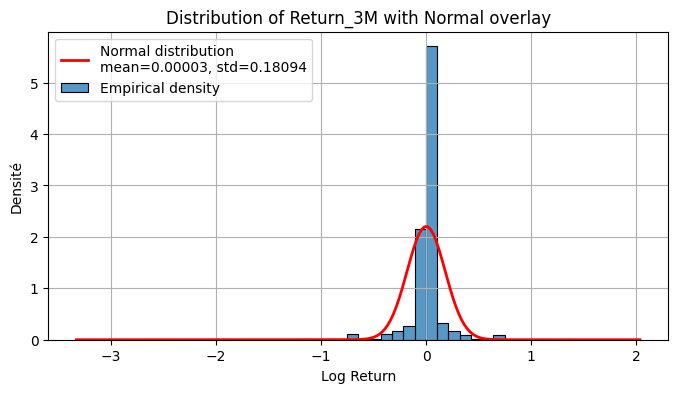

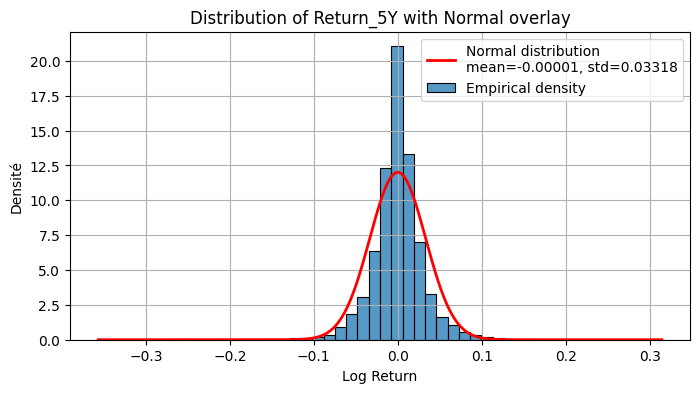

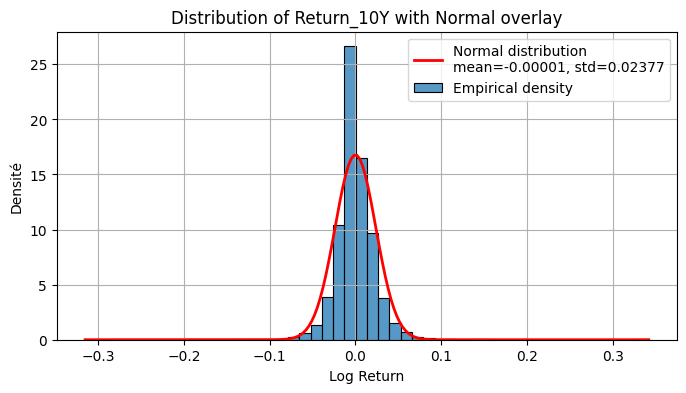

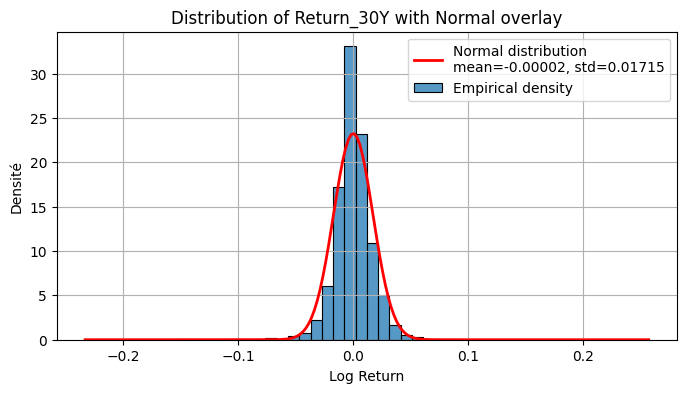

In [ ]:
import seaborn as sns
for yld in ["Return_3M", "Return_5Y", "Return_10Y", "Return_30Y"]:
    data = df_merged[yld].dropna()

    mu, std = norm.fit(data)

    plt.figure(figsize=(8, 4))
    sns.histplot(data, kde=False, stat="density", bins=50, label="Empirical density")

    x = np.linspace(data.min(), data.max(), 200)
    pdf = norm.pdf(x, mu, std)
    plt.plot(x, pdf, "r-", lw=2, label=f"Normal distribution\nmean={mu:.5f}, std={std:.5f}")

    plt.title(f"Distribution of {yld} with Normal overlay")
    plt.xlabel("Log Return")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.show()

We then merge both datasets, the one with the sentiment metrics and the other one with the macro and returns time series


In [ ]:
df_speeches.sort_values("date", inplace=True)
df_speeches.dropna(subset=['date'], inplace=True)
df_merged.sort_values("Date", inplace=True)

df_final = pd.merge_asof(
    df_merged,
    df_speeches,
    left_on="Date",
    right_on="date",
    direction="backward"
)

In [ ]:
#df_index = pd.read_csv("index.csv")
url_index = "https://raw.githubusercontent.com/cominho/Machine-Learning-for-Portfolio-Management-and-Trading/main/index.csv"
df_index = pd.read_csv(url_index)
df_index

df_index["Date"] = pd.to_datetime(df_index[["Year", "Month", "Day"]])
df_index.sort_values("Date", inplace=True)

df_final = pd.merge(
    df_final,
    df_index,
    on="Date",
    how="left"
)

df_final["Effective Federal Funds Rate"].fillna(method="ffill", inplace=True)
df_final["Real GDP (Percent Change)"].fillna(method="ffill", inplace=True)
df_final["Unemployment Rate"].fillna(method="ffill", inplace=True)
df_final["Inflation Rate"].fillna(method="ffill", inplace=True)

<ipython-input-31-2dd1f9a8d8a6>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final["Effective Federal Funds Rate"].fillna(method="ffill", inplace=True)
<ipython-input-31-2dd1f9a8d8a6>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final["Effective Federal Funds Rate"].fillna(method="ffill", inplace=True)
<ipython-input-31-2dd1f9a8d8a6>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through c

In [ ]:
# We have to clean every inf and NaN
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.fillna(method="ffill", inplace=True)
df_final = df_final[df_final["rlo_score"].notna()]
df_final.reset_index(drop=True, inplace=True)
df_final

<ipython-input-32-71559dc60abc>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method="ffill", inplace=True)


,Date,Close_3M,Close_5Y,Close_10Y,Close_30Y,Return_3M,Return_5Y,Return_10Y,Return_30Y,Spread_5Y_3M,...,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,2006-01-18,4.35,4.28,4.34,4.53,-0.006873,0.002339,0.000000,0.002210,-0.07,...,2005.0,12.0,13.0,4.25,NaN,NaN,4.16,3.4,4.9,2.2
1,2006-01-19,4.35,4.31,4.38,4.51,0.000000,0.006985,0.009174,-0.004425,-0.04,...,2005.0,12.0,13.0,4.25,NaN,NaN,4.16,3.4,4.9,2.2
2,2006-01-20,4.35,4.31,4.37,4.54,0.000000,0.000000,-0.002286,0.006630,-0.04,...,2005.0,12.0,13.0,4.25,NaN,NaN,4.16,3.4,4.9,2.2
3,2006-01-23,4.38,4.30,4.36,4.54,0.006873,-0.002323,-0.002291,0.000000,-0.08,...,2005.0,12.0,13.0,4.25,NaN,NaN,4.16,3.4,4.9,2.2
4,2006-01-24,4.40,4.32,4.40,4.53,0.004556,0.004640,0.009132,-0.002205,-0.08,...,2005.0,12.0,13.0,4.25,NaN,NaN,4.16,3.4,4.9,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4932,2024-12-13,4.34,4.25,4.40,4.61,-0.002301,0.016608,0.018349,0.013101,-0.09,...,2017.0,3.0,16.0,1.00,1.0,0.75,0.66,3.5,4.7,2.2
4933,2024-12-16,4.37,4.25,4.39,4.60,0.006889,0.000000,-0.002275,-0.002172,-0.12,...,2017.0,3.0,16.0,1.00,1.0,0.75,0.66,3.5,4.7,2.2
4934,2024-12-17,4.38,4.26,4.40,4.59,0.002286,0.002350,0.002275,-0.002176,-0.12,...,2017.0,3.0,16.0,1.00,1.0,0.75,0.66,3.5,4.7,2.2
4935,2024-12-18,4.36,4.40,4.50,4.65,-0.004577,0.032335,0.022473,0.012987,0.04,...,2017.0,3.0,16.0,1.00,1.0,0.75,0.66,3.5,4.7,2.2


### Correlation and causality analysis

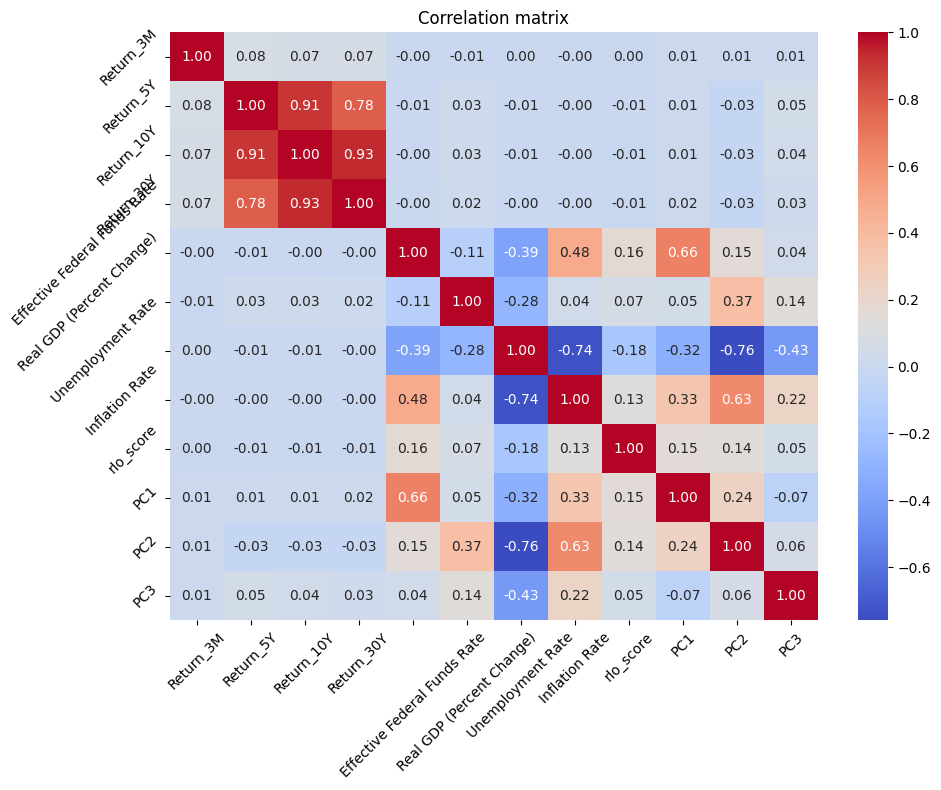

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

p-values matrix (Granger causality) on lag=1..3 :
                              Return_3M  Return_5Y  Return_10Y  Return_30Y  \
Return_3M                           NaN     0.0032      0.0100      0.0724   
Return_5Y                        0.0022        NaN      0.0000      0.0000   
Return_10Y                       0.0028     0.0020         NaN      0.0000   
Return_30Y                       0.0007     0.0011      0.0000         NaN   
Effective Federal Funds Rate     0.0009     0.3078      0.5028      0.4747   
Real GDP (Percent Change)        0.2155     0.0941      0.3193      0.1523   
Unemployment Rate                0.4469     0.7772      0.5230      0.6266   
Inflation Rate                   0.0004     0.4040      0.6736      0.8733   
rlo_score                        0.1181     0.2098      0.2495      0.0557   
PC1                              0.0094     0.0547      0.0048      0.0000   
PC2                              0.0000     0.0002      0.0009      0.0000   
PC3           

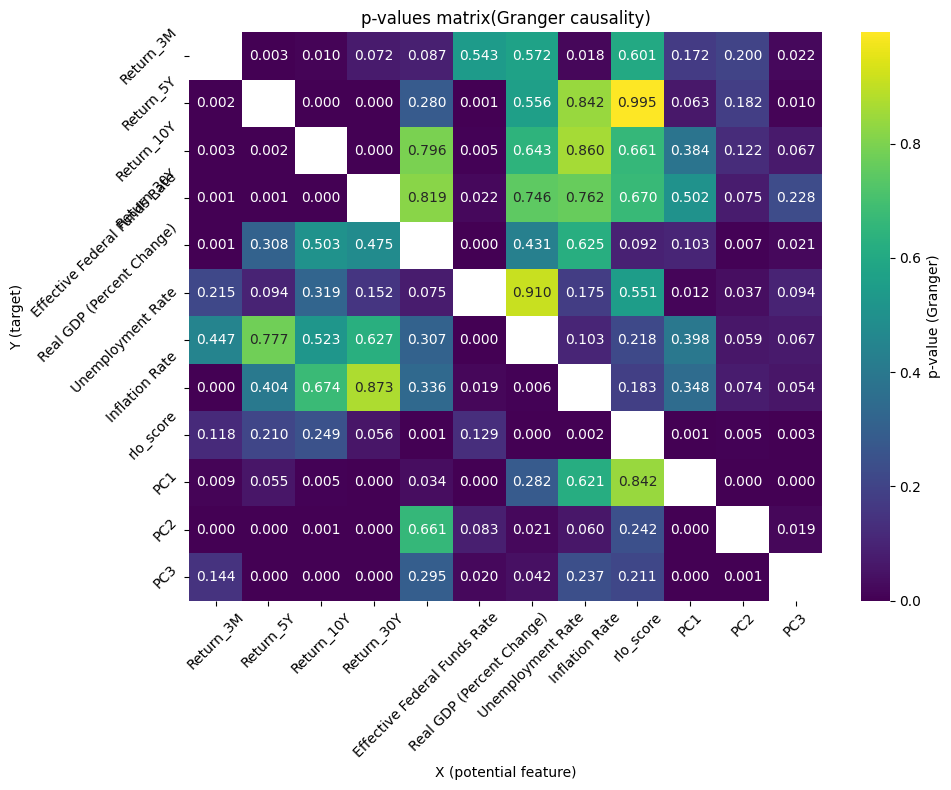

In [ ]:
corr_vars = [
    "Return_3M",
    "Return_5Y",
    "Return_10Y",
    "Return_30Y",
    "Effective Federal Funds Rate",
    "Real GDP (Percent Change)",
    "Unemployment Rate",
    "Inflation Rate",
    "rlo_score",
    "PC1",
    "PC2",
    "PC3"
]

df_corr = df_final[corr_vars].dropna()

# Heatmap of correlation
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Granger Causality test
def grangers_causation_matrix(data, variables, maxlag=3, test='ssr_chi2test', verbose=False):


    dataset = data[variables].dropna()
    df_res = pd.DataFrame(np.zeros((len(variables), len(variables))),
                          columns=variables, index=variables)

    for col_x in df_res.columns:
        for row_y in df_res.index:
            if row_y == col_x:
                df_res.loc[row_y, col_x] = np.nan
            else:
                # Test "X ne cause pas Y"
                result = grangercausalitytests(dataset[[row_y, col_x]],
                                               maxlag=maxlag,
                                               verbose=verbose)

                p_values = [
                    round(result[lag+1][0][test][1], 4)
                    for lag in range(maxlag)
                ]

                min_p_value = np.min(p_values)
                df_res.loc[row_y, col_x] = min_p_value
    return df_res

max_lag = 3
causality_df = grangers_causation_matrix(df_corr, corr_vars, maxlag=max_lag, test='ssr_chi2test', verbose=False)

print(f"p-values matrix (Granger causality) on lag=1..{max_lag} :")
print(causality_df)

# Granger p-values Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(causality_df.astype(float), annot=True, cmap="viridis", fmt=".3f",
            cbar_kws={'label': 'p-value (Granger)'})
plt.title("p-values matrix(Granger causality)")
plt.xlabel("X (potential feature)")
plt.ylabel("Y (target)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


We will now implement a Random Forest with TimeSeriesSplit, incorporating :  
- Lagged values of Return_3M, Return_5Y, Return_10Y, Return_30Y.  
- Fed Funds Rate and its lagged history.  
- Macro variables (GDP, Inflation, Unemployment) if aiming for longer timeframes.  
- Ensure proper handling of data leakage and temporal alignment.

## 4 - Empirical results
Our trading strategy seeks to predict the log-return of the 10Y Treasury yield using lagged returns (1 to 3 days) of various maturities (3M, 5Y, 10Y, 30Y), the rlo_score (a sentiment metric derived from FOMC speeches) and the Effective Federal Funds Rate, to generate a trading signal (long or short) based on these predictions.

#### Quick recap about our methodology
1. **TimeSeriesSplit** : The dataset is divided into 5 time-based folds to prevent lookahead bias.
2. **Model Training** : A Random Forest Regressor is used to predict the sign and magnitude of the 10Y log-returns.
3. **Trading Signal** :
   - \(+1\) if the prediction is positive, \(-1\) if negative.
   - Strategy returns are calculated as $$\text{Signal} \times \text{Return}_{10Y}$$
4. **Evaluation metrics** : Sharpe Ratio, Maximum Drawdown (MaxDD) and fold-wise performance.



In [ ]:
def backtest_logreturns_in_logdomain(df, features, target, n_splits=5):
    """
    Backtest for a target = log-return, keeping the cumulative return in the "log domain"
    (we do not apply np.exp(cumsum) - 1, but directly plot the cumulative sum).

    Parameters:
    - df        : DataFrame containing "Date", features, target (log-return)
    - features  : list of feature columns (X)
    - target    : name of the target column (Y, log-return)
    - n_splits  : number of folds for TimeSeriesSplit

    Output:
    - df_all    : concatenated DataFrame with results
    - df_metrics: fold-by-fold performance metrics
    """
    feature_importances_all = []
    df_local = df.copy().dropna(subset=features + [target])
    df_local.sort_values("Date", inplace=True)
    df_local.reset_index(drop=True, inplace=True)

    X_all = df_local[features]
    y_all = df_local[target]
    dates = df_local["Date"]

    tscv = TimeSeriesSplit(n_splits=n_splits)

    all_folds_results = []
    all_folds_metrics = []

    fold_num = 1

    for train_idx, test_idx in tscv.split(X_all):
        print(f"\n Fold {fold_num}/{n_splits} ")

        X_train = X_all.iloc[train_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
        X_test  = X_all.iloc[test_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")

        y_train = y_all.iloc[train_idx]
        y_test  = y_all.iloc[test_idx]

        dates_train = dates.iloc[train_idx]
        dates_test  = dates.iloc[test_idx]

        X_train.dropna(inplace=True)
        X_test.dropna(inplace=True)

        y_train = y_train.loc[X_train.index]
        y_test  = y_test.loc[X_test.index]

        if len(X_train) == 0 or len(X_test) == 0:
            print("Pas de données dans ce fold => skip.")
            fold_num += 1
            continue

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=5,
            min_samples_split=5,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)

        df_test = pd.DataFrame({
            "Date": dates_test.loc[X_test.index].values,
            "y_true": y_test.values,
            "y_pred": y_pred           # predicted log-return
        })
        df_test.sort_values("Date", inplace=True)
        df_test.reset_index(drop=True, inplace=True)

        #Signal : +1 if y_pred > 0, -1 else
        df_test["Signal"] = np.where(df_test["y_pred"] > 0, 1, -1)

        df_test["Strategy_LogRet"] = df_test["Signal"] * df_test["y_true"]

        mean_ret = df_test["Strategy_LogRet"].mean()
        std_ret  = df_test["Strategy_LogRet"].std()
        sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else np.nan

        df_test["Cumulative_Strategy_Log"] = df_test["Strategy_LogRet"].cumsum()
        df_test["Cumulative_BH_Log"]       = df_test["y_true"].cumsum()


        capital_curve = np.exp(df_test["Cumulative_Strategy_Log"])
        roll_max_cap  = capital_curve.cummax()
        dd_series     = (roll_max_cap - capital_curve) / roll_max_cap
        max_dd        = dd_series.max()

        metrics_fold = {
            "Fold": fold_num,
            "Start": df_test["Date"].iloc[0],
            "End":   df_test["Date"].iloc[-1],
            "Sharpe": sharpe,
            "MaxDD%": max_dd * 100
        }
        all_folds_metrics.append(metrics_fold)

        plt.figure(figsize=(10, 4))
        plt.plot(df_test["Date"], df_test["Cumulative_Strategy_Log"], label="Strategy (sum of log-returns)")
        plt.plot(df_test["Date"], df_test["Cumulative_BH_Log"],       label="Buy & Hold (sum of log-returns)")
        plt.title(f"Fold {fold_num} : Cumulative (Log Domain)")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()

        feature_importances = model.feature_importances_
        feature_importances_all.append(feature_importances)

        df_test["Fold"] = fold_num
        all_folds_results.append(df_test)
        fold_num += 1

    df_metrics = pd.DataFrame(all_folds_metrics)
    print("\n Métriques par Fold ")
    print(df_metrics)

    print("\nSharpe moyen : ", df_metrics["Sharpe"].mean())
    print("MaxDD moyen (%) : ", df_metrics["MaxDD%"].mean())

    if not all_folds_results:
        print("Aucun fold exploitable.")
        return None, None

    df_all = pd.concat(all_folds_results).sort_values("Date").reset_index(drop=True)

    df_all["Global_Strategy_Log"] = df_all["Strategy_LogRet"].cumsum()
    df_all["Global_BH_Log"]       = df_all["y_true"].cumsum()

    # Sharpe global
    mean_g = df_all["Strategy_LogRet"].mean()
    std_g  = df_all["Strategy_LogRet"].std()
    sharpe_g = (mean_g / std_g) * np.sqrt(252) if std_g != 0 else np.nan

    capital_global = np.exp(df_all["Global_Strategy_Log"])
    roll_max_glob  = capital_global.cummax()
    dd_global      = (roll_max_glob - capital_global) / roll_max_glob
    max_dd_global  = dd_global.max()

    print("\n Global performance (log domain) ")
    print(f"Sharpe Ratio : {sharpe_g:.2f}")
    print(f"Max Drawdown : {max_dd_global*100:.2f}%")


    plt.figure(figsize=(10, 5))
    plt.plot(df_all["Date"], df_all["Global_Strategy_Log"], label="Strategy (cumulative log)")
    plt.plot(df_all["Date"], df_all["Global_BH_Log"], label="Buy & Hold (cumulative log)")
    plt.title("Global performance (Log Domain)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

    avg_importance = np.mean(feature_importances_all, axis=0)
    print("\n Average significance of explanatory variables :")
    for i, var in enumerate(features):
        print(f"{var}: {avg_importance[i]:.4f}")

    return df_all, df_metrics



/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-34-a0eee20d8f2f>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_all.iloc[train_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
<ipython-input-34-a0eee20d8f2f>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test  = X_all.iloc[test_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")



 Fold 1/5 


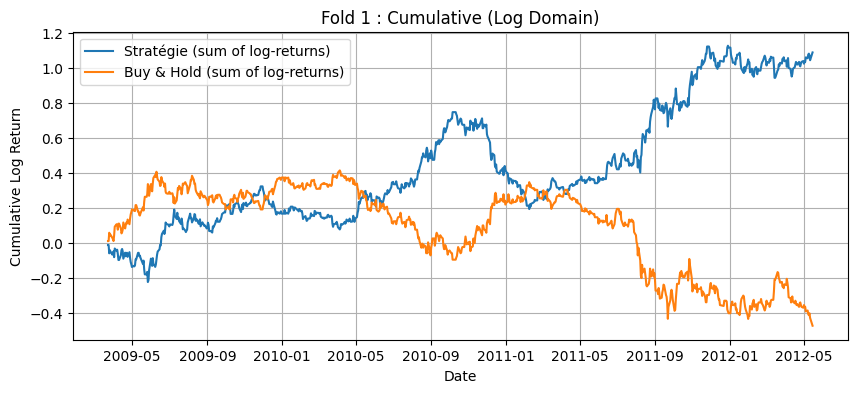


 Fold 2/5 


<ipython-input-34-a0eee20d8f2f>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_all.iloc[train_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
<ipython-input-34-a0eee20d8f2f>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test  = X_all.iloc[test_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


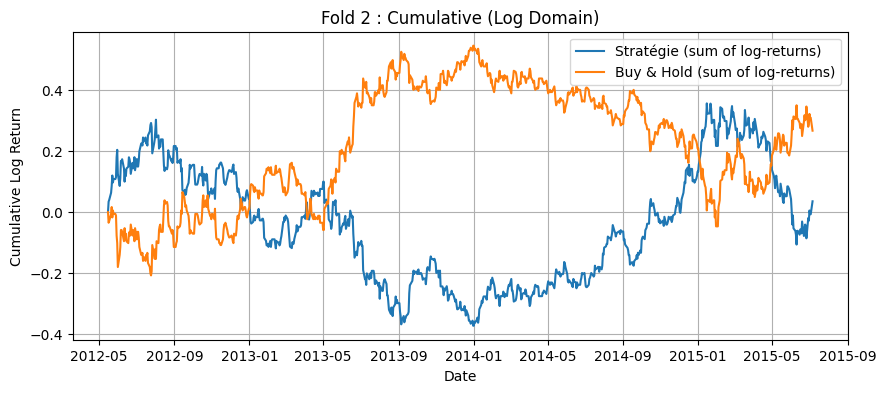


 Fold 3/5 


<ipython-input-34-a0eee20d8f2f>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_all.iloc[train_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
<ipython-input-34-a0eee20d8f2f>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test  = X_all.iloc[test_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


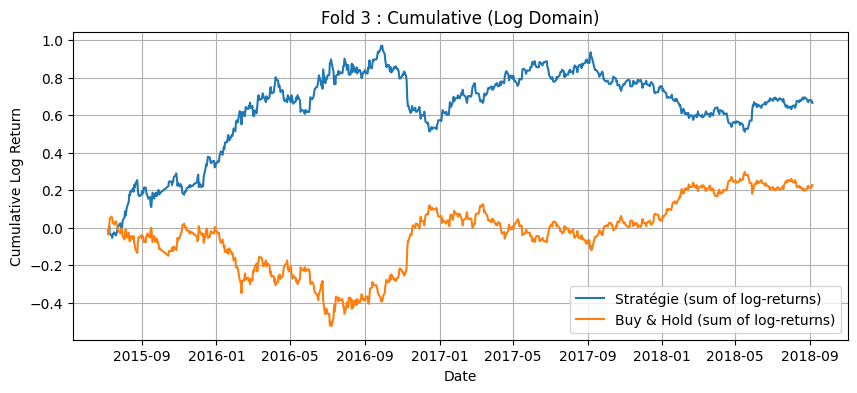


 Fold 4/5 


<ipython-input-34-a0eee20d8f2f>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_all.iloc[train_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
<ipython-input-34-a0eee20d8f2f>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test  = X_all.iloc[test_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


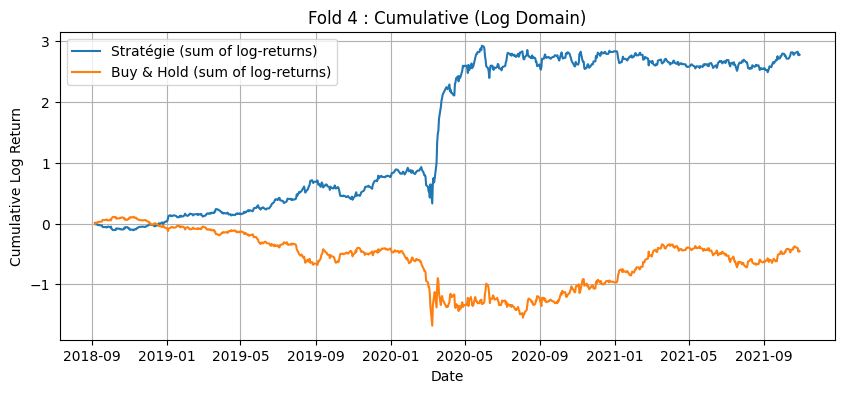


 Fold 5/5 


<ipython-input-34-a0eee20d8f2f>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_all.iloc[train_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
<ipython-input-34-a0eee20d8f2f>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test  = X_all.iloc[test_idx].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


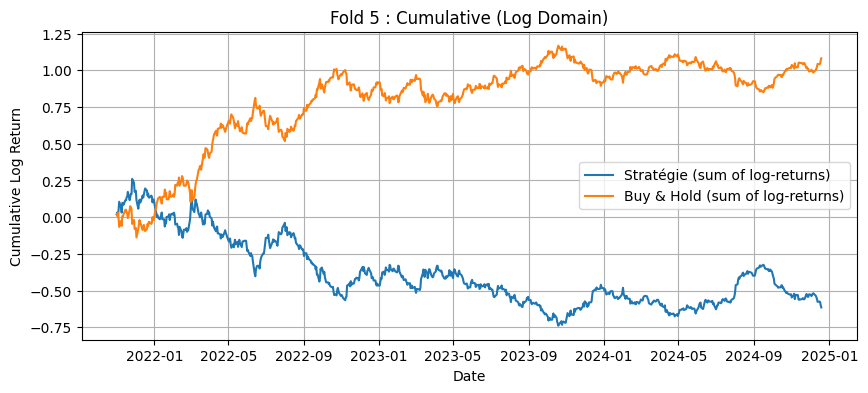


 Métriques par Fold 
   Fold      Start        End    Sharpe     MaxDD%
0     1 2009-03-23 2012-05-15  0.910644  42.469044
1     2 2012-05-16 2015-07-06  0.032236  49.157448
2     3 2015-07-07 2018-09-05  0.682806  36.812003
3     4 2018-09-06 2021-10-29  1.285636  45.088616
4     5 2021-11-01 2024-12-19 -0.552478  63.204478

Sharpe moyen :  0.47176895653211426
MaxDD moyen (%) :  47.34631781602227

 Global performance (log domain) 
Sharpe Ratio : 0.57
Max Drawdown : 63.20%


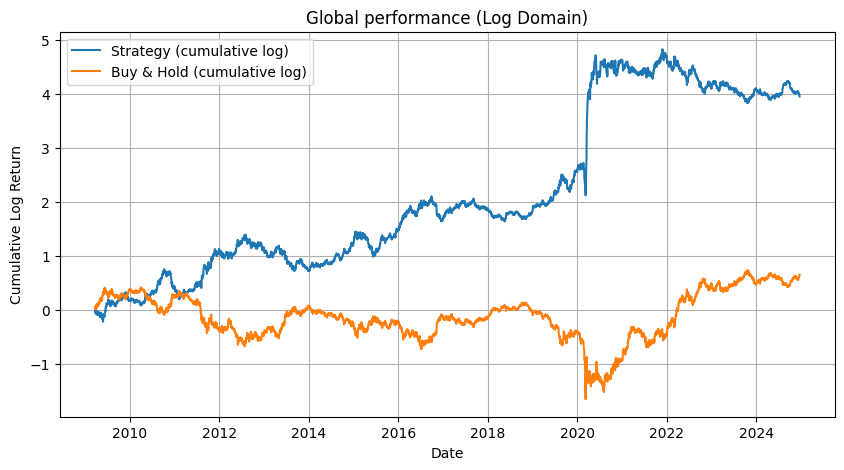


 Average significance of explanatory variables :
Return_3M_Lag1: 0.0878
Return_3M_Lag2: 0.0677
Return_3M_Lag3: 0.0444
Return_5Y_Lag1: 0.0550
Return_5Y_Lag2: 0.0641
Return_5Y_Lag3: 0.0317
Return_10Y_Lag1: 0.1529
Return_10Y_Lag2: 0.1186
Return_10Y_Lag3: 0.0686
Return_30Y_Lag1: 0.0972
Return_30Y_Lag2: 0.1212
Return_30Y_Lag3: 0.0680
rlo_score: 0.0228


In [ ]:
for col in ["Close_3M", "Close_5Y", "Close_10Y", "Close_30Y"]:
    # Log-returns
    df_final[f"Return_{col.split('_')[-1]}"] = np.log(df_final[col] / df_final[col].shift(1))
    # Lags de 1 à 3 jours
    for lag in range(1, 4):
        df_final[f"Return_{col.split('_')[-1]}_Lag{lag}"] = df_final[f"Return_{col.split('_')[-1]}"].shift(lag)

# Variables explicatives et cible
features = [
    "Return_3M_Lag1", "Return_3M_Lag2", "Return_3M_Lag3",
    "Return_5Y_Lag1", "Return_5Y_Lag2", "Return_5Y_Lag3",
    "Return_10Y_Lag1", "Return_10Y_Lag2", "Return_10Y_Lag3",
    "Return_30Y_Lag1", "Return_30Y_Lag2", "Return_30Y_Lag3",
    "rlo_score"
]
df_result, df_folds_metrics = backtest_logreturns_in_logdomain(
     df=df_final,
     features=features,
     target="Return_10Y",
     n_splits=5
 )



## 5 - Strategy limitations and areas for improvement

We have identified some areas for improvement to our strategy, the main ones being :

**High drawdowns** : The MaxDD (63.83\%) indicates a need for improved risk management, such as dynamic stop-loss mechanisms or better position sizing.

**rlo_score potential** : Incorporating additional sources of sentiment data could enhance its predictive power.

**Macro and technical Factors** : Adding broader macroeconomic indicators (inflation, GDP growth) or technical signals (momentum, volatility) may improve performance.

**Feature engineering** : Exploring non-linear transformations and interactions between features could yield stronger predictive signals.

**Signal thresholds** : Ignoring small predictions or applying trend-following filters could help reduce noise and stabilize returns.

In addition, testing our signal on other asset classes (e.g sector ETFs) could be interesting.


## 6 - Conclusion
This strategy demonstrates the feasibility of combining lagged returns and sentiment analysis to generate trading signals. While the rlo score provides a qualitative edge, its impact is modest relative to quantitative signals. To further enhance performance, a focus on risk management and signal filtering is necessary. Expanding the feature set to include more diverse macro and sentiment data sources could unlock greater potential.
